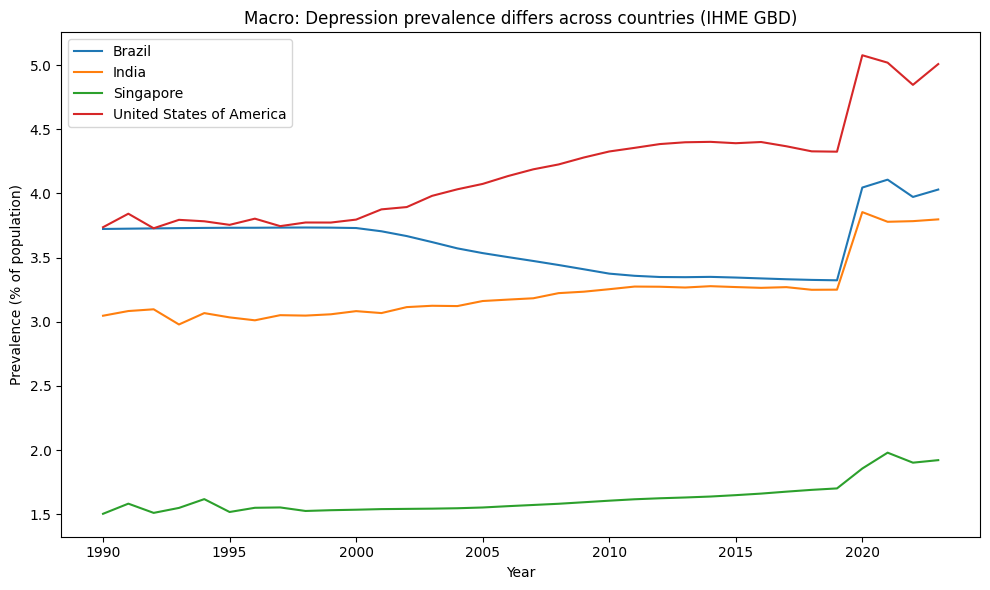

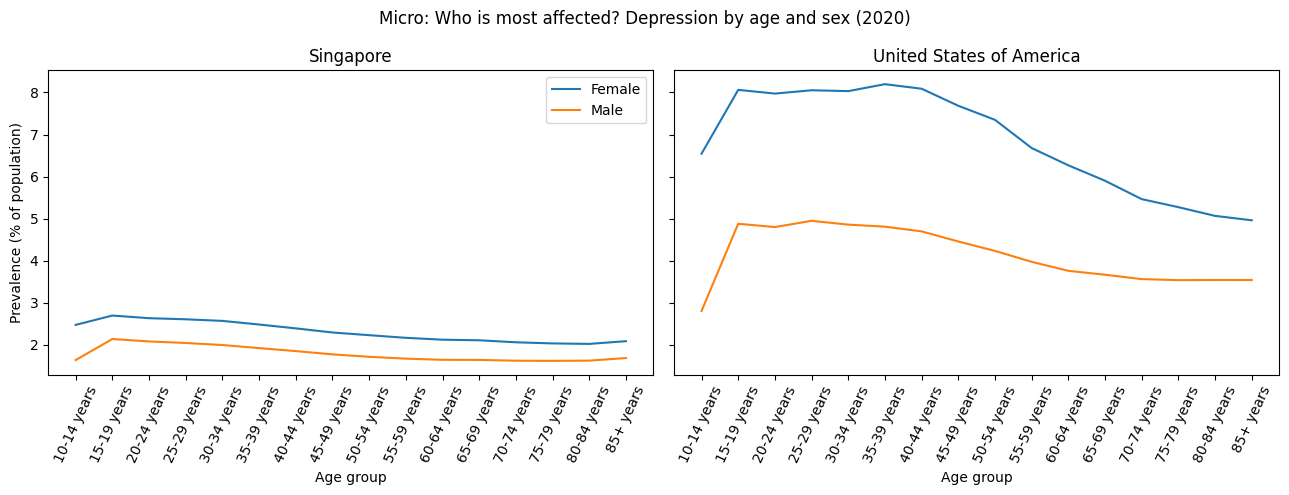

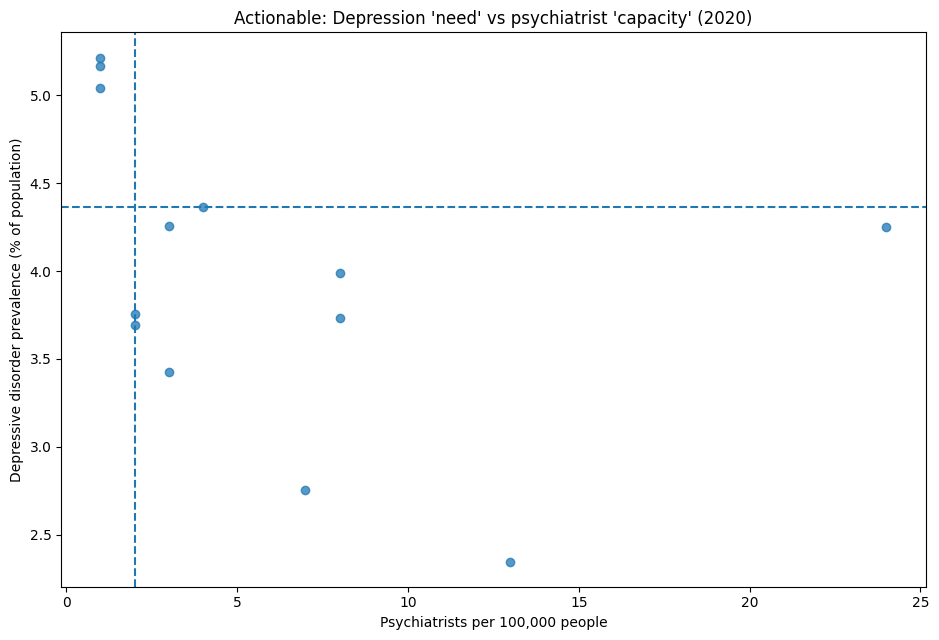

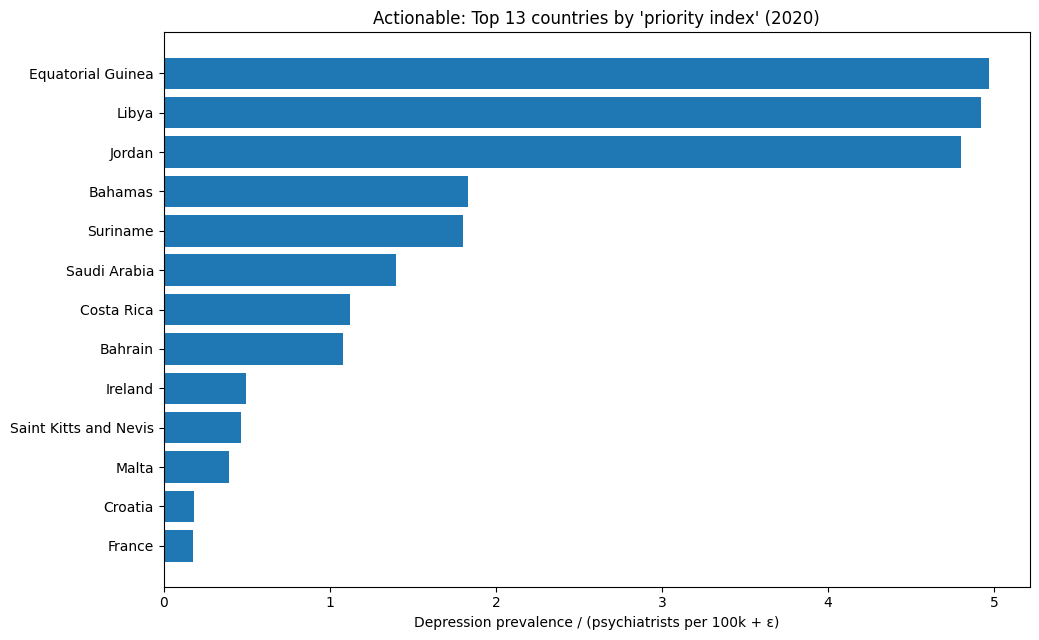


Saved plots to output/:
 - plot1_macro_depression_trend.png
 - plot2_micro_age_sex_profiles.png
 - plot3_actionable_need_vs_capacity_scatter.png
 - plot3_actionable_priority_index_top13.png

Actionable merge year: 2020
Merged rows: 13
Thresholds: capacity 25th pct = 2.00, need 75th pct = 4.37%
         location  year  dep_prev  psy_per100k
           France  2020  4.248176           24
          Ireland  2020  3.988629            8
          Bahrain  2020  4.366062            4
           Jordan  2020  5.042136            1
       Costa Rica  2020  3.424884            3
          Croatia  2020  2.347550           13
Equatorial Guinea  2020  5.215020            1
            Malta  2020  2.754261            7
          Bahamas  2020  3.758628            2
     Saudi Arabia  2020  4.258913            3


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

ROOT_DIR = Path.cwd().parent
DATA_DIR = ROOT_DIR / "data"
OUT_DIR = ROOT_DIR / "output"
OUT_DIR.mkdir(exist_ok=True)

IHME_MACRO = DATA_DIR / "ihme_depression_macro.csv"
IHME_MICRO = DATA_DIR / "ihme_depression_micro.csv"
IHME_ALL = DATA_DIR / "ihme_depression_2020_allcountries.csv"
PSY_FILE = DATA_DIR / "psychiatrists_per100k.csv"

MACRO_LOCATIONS = ["Singapore", "United States of America", "India", "Brazil", "Japan", "World"]
MICRO_LOCATIONS = ["Singapore", "United States of America"]
MICRO_YEAR = 2020

def load_ihme(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.rename(columns={
        "location_name": "location",
        "sex_name": "sex",
        "age_name": "age",
        "cause_name": "cause",
        "measure_name": "measure",
        "metric_name": "metric",
        "val": "value"
    })
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    if "upper" in df.columns:
        df["upper"] = pd.to_numeric(df["upper"], errors="coerce")
    if "lower" in df.columns:
        df["lower"] = pd.to_numeric(df["lower"], errors="coerce")
    if "metric" in df.columns:
        is_percent = df["metric"].astype(str).str.contains("Percent", case=False, na=False).any()
        if is_percent and df["value"].max() <= 1.0:
            df["value"] *= 100
            if "upper" in df.columns:
                df["upper"] *= 100
            if "lower" in df.columns:
                df["lower"] *= 100
    return df

def load_psychiatrists(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    value_col = "Total number of psychiatrists per 100,000 population"
    df = df.rename(columns={
        "Entity": "location",
        "Year": "year",
        value_col: "psy_per100k"
    })
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df["psy_per100k"] = pd.to_numeric(df["psy_per100k"], errors="coerce")
    return df[["location", "year", "psy_per100k"]]

def age_sort_key(age_str: str) -> float:
    s = str(age_str).strip().lower()
    digits = ""
    for ch in s:
        if ch.isdigit():
            digits += ch
        elif digits:
            break
    return float(digits) if digits else 999.0

def choose_actionable_year(need_all: pd.DataFrame, psy: pd.DataFrame) -> int:
    need_years = set(need_all["year"].dropna().unique().astype(int))
    psy_counts = (
        psy.dropna(subset=["psy_per100k"])
           .groupby("year")["location"]
           .nunique()
           .sort_values(ascending=False)
    )
    candidates = [int(y) for y in psy_counts.index if int(y) in need_years]
    if not candidates:
        raise ValueError(
            "No overlapping years between IHME all-countries file and psychiatrists file.\n"
            f"IHME years: {sorted(list(need_years))[:10]}...\n"
            f"Psych years: {sorted(list(set(psy['year'].dropna().unique().astype(int))))[:10]}...\n"
            "Export IHME all-countries for a year that exists in psychiatrists data (often 2020/2017)."
        )
    return candidates[0]

def plot_macro_trend(df_macro: pd.DataFrame, locations: list[str], outpath: Path):
    sub = df_macro[df_macro["location"].isin(locations)].copy()
    sub = sub.dropna(subset=["year", "value"]).sort_values(["location", "year"])
    plt.figure(figsize=(10, 6))
    for loc, g in sub.groupby("location"):
        plt.plot(g["year"], g["value"], label=loc)
    plt.title("Macro: Depression prevalence differs across countries (IHME GBD)")
    plt.xlabel("Year")
    plt.ylabel("Prevalence (% of population)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=240)
    plt.show()
    plt.close()

def plot_micro_age_sex(df_micro: pd.DataFrame, year: int, locations: list[str], outpath: Path):
    sub = df_micro[(df_micro["year"] == year) & (df_micro["location"].isin(locations))].copy()
    sub = sub.dropna(subset=["value"])
    sexes = set(sub["sex"].unique())
    if not (("Male" in sexes) and ("Female" in sexes)):
        raise ValueError(
            "Micro plot requires sex split, but your micro dataset does not contain BOTH 'Male' and 'Female'.\n"
            f"Sexes present: {sorted(list(sexes))}\n"
            "Re-export micro from IHME with Sex = Male and Female (not Both)."
        )
    sub = sub[sub["sex"].isin(["Male", "Female"])].copy()
    ages = sorted(sub["age"].unique(), key=age_sort_key)
    sub["age"] = pd.Categorical(sub["age"], categories=ages, ordered=True)
    sub = sub.sort_values(["location", "sex", "age"])
    fig, axes = plt.subplots(1, len(locations), figsize=(13, 5), sharey=True)
    if len(locations) == 1:
        axes = [axes]
    for ax, loc in zip(axes, locations):
        g = sub[sub["location"] == loc]
        for sex in ["Female", "Male"]:
            gg = g[g["sex"] == sex]
            ax.plot(gg["age"].astype(str), gg["value"], label=sex)
        ax.set_title(loc)
        ax.set_xlabel("Age group")
        ax.tick_params(axis="x", rotation=65)
    axes[0].set_ylabel("Prevalence (% of population)")
    axes[0].legend()
    plt.suptitle(f"Micro: Who is most affected? Depression by age and sex ({year})")
    plt.tight_layout()
    plt.savefig(outpath, dpi=240)
    plt.show()
    plt.close()

def plot_actionable(need_all: pd.DataFrame, psy: pd.DataFrame, year: int, out_scatter: Path, out_bar: Path, highlight=("Singapore", "United States of America")):
    need_y = need_all[need_all["year"] == year].copy()
    need_y = need_y.rename(columns={"value": "dep_prev"}).dropna(subset=["dep_prev"])
    psy_y = psy[psy["year"] == year].copy()
    psy_y = psy_y.dropna(subset=["psy_per100k"])
    merged = need_y.merge(psy_y, on=["location", "year"], how="inner")
    merged = merged.dropna(subset=["dep_prev", "psy_per100k"])
    merged = merged[merged["psy_per100k"] > 0].copy()
    x = merged["psy_per100k"]
    y = merged["dep_prev"]
    x_thr = x.quantile(0.25)
    y_thr = y.quantile(0.75)
    plt.figure(figsize=(9.5, 6.5))
    plt.scatter(merged["psy_per100k"], merged["dep_prev"], alpha=0.75)
    plt.axvline(x_thr, linestyle="--")
    plt.axhline(y_thr, linestyle="--")
    hl = merged[merged["location"].isin(list(highlight))]
    if not hl.empty:
        plt.scatter(hl["psy_per100k"], hl["dep_prev"], s=90)
        for _, r in hl.iterrows():
            plt.annotate(r["location"], (r["psy_per100k"], r["dep_prev"]), textcoords="offset points", xytext=(6, 6))
    plt.title(f"Actionable: Depression 'need' vs psychiatrist 'capacity' ({year})")
    plt.xlabel("Psychiatrists per 100,000 people")
    plt.ylabel("Depressive disorder prevalence (% of population)")
    plt.tight_layout()
    plt.savefig(out_scatter, dpi=240)
    plt.show()
    plt.close()
    eps = 0.05
    merged["priority_index"] = merged["dep_prev"] / (merged["psy_per100k"] + eps)
    top = merged.sort_values("priority_index", ascending=False).head(15)
    plt.figure(figsize=(10.5, 6.5))
    plt.barh(top["location"], top["priority_index"])
    plt.gca().invert_yaxis()
    plt.title(f"Actionable: Top 13 countries by 'priority index' ({year})")
    plt.xlabel("Depression prevalence / (psychiatrists per 100k + ε)")
    plt.tight_layout()
    plt.savefig(out_bar, dpi=240)
    plt.show()
    plt.close()
    return merged, x_thr, y_thr

def main():
    macro = load_ihme(IHME_MACRO)
    micro = load_ihme(IHME_MICRO)
    need_all = load_ihme(IHME_ALL)
    psy = load_psychiatrists(PSY_FILE)
    plot_macro_trend(macro, MACRO_LOCATIONS, OUT_DIR / "plot1_macro_depression_trend.png")
    plot_micro_age_sex(micro, MICRO_YEAR, MICRO_LOCATIONS, OUT_DIR / "plot2_micro_age_sex_profiles.png")
    actionable_year = choose_actionable_year(need_all, psy)
    merged, x_thr, y_thr = plot_actionable(
        need_all,
        psy,
        year=actionable_year,
        out_scatter=OUT_DIR / "plot3_actionable_need_vs_capacity_scatter.png",
        out_bar=OUT_DIR / "plot3_actionable_priority_index_top13.png",
        highlight=("Singapore", "United States of America")
    )
    print("\nSaved plots to output/:")
    print(" - plot1_macro_depression_trend.png")
    print(" - plot2_micro_age_sex_profiles.png")
    print(" - plot3_actionable_need_vs_capacity_scatter.png")
    print(" - plot3_actionable_priority_index_top13.png")
    print("\nActionable merge year:", actionable_year)
    print("Merged rows:", len(merged))
    print(f"Thresholds: capacity 25th pct = {x_thr:.2f}, need 75th pct = {y_thr:.2f}%")
    print(merged[["location", "year", "dep_prev", "psy_per100k"]].head(10).to_string(index=False))

main()